In [1]:
%load_ext autoreload
%autoreload 2

## Making plots for potential prognostic predictability

In [2]:
import xarray as xr
import numpy as np
import gfdl_utils as gu
import glob
from dask.diagnostics import ProgressBar
from information import *
from processing import *
from variance import *
from plotting import *
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl

### PPP, global map

In [3]:
variable = 'siconc'
frequency = 'monthly'
grid = xr.open_dataset(get_gridpath(variable,frequency))

In [5]:
lead = 1

/work/gam/projects/esm4_ppe/data/processed/skill/ppp.e2c/ice_month.01.zarr/siconc already saved.


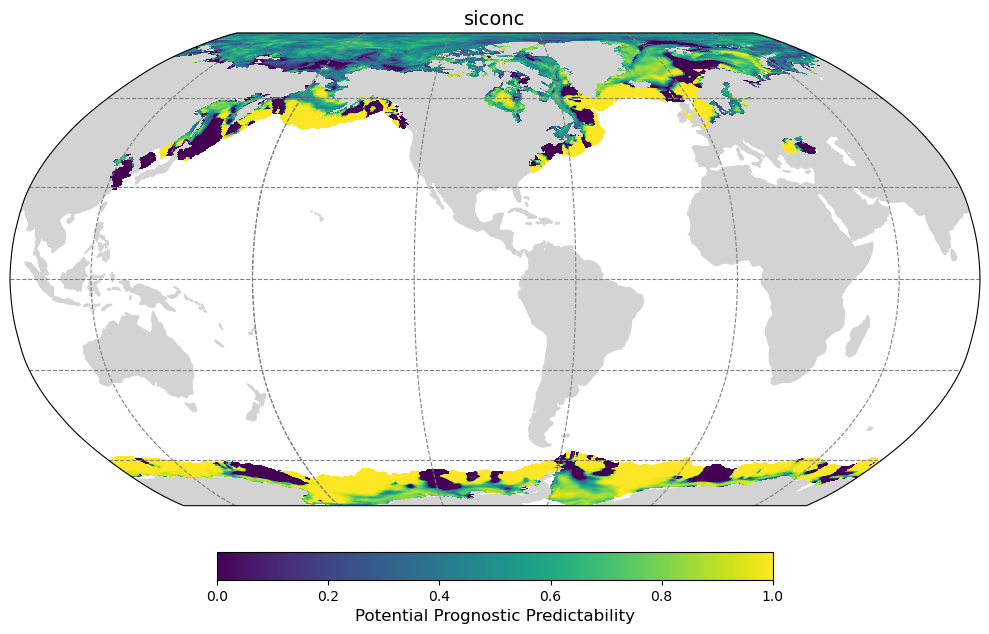

In [9]:
startmonth = 1
ds = calc_ppp(variable,frequency,startmonth=startmonth)
fig,ax,im,cbar = draw_globalmap(ds[variable].sel(time=lead),grid,cname='Potential Prognostic Predictability')
im.set_clim([0,1])

In [7]:
grid

<xarray.Dataset>
Dimensions:    (yT: 576, xT: 720, xTe: 721, yTe: 577)
Coordinates:
  * xT         (xT) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * xTe        (xTe) float64 -300.0 -299.5 -299.0 -298.5 ... 58.5 59.0 59.5 60.0
  * yT         (yT) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * yTe        (yTe) float64 -78.0 -77.82 -77.63 -77.45 ... 89.58 89.79 90.0
Data variables:
    area       (yT, xT) float32 ...
    lat        (yT, xT) float32 ...
    lon        (yT, xT) float32 ...
    mask       (yT, xT) float32 ...
    CELL_AREA  (yT, xT) float32 ...
    COSROT     (yT, xT) float32 ...
    GEOLAT     (yT, xT) float32 ...
    GEOLON     (yT, xT) float32 ...
    SINROT     (yT, xT) float32 ...

/work/gam/projects/esm4_ppe/data/processed/ppp/ocean_cobalt_omip_2d.04.zarr/intpp already saved.


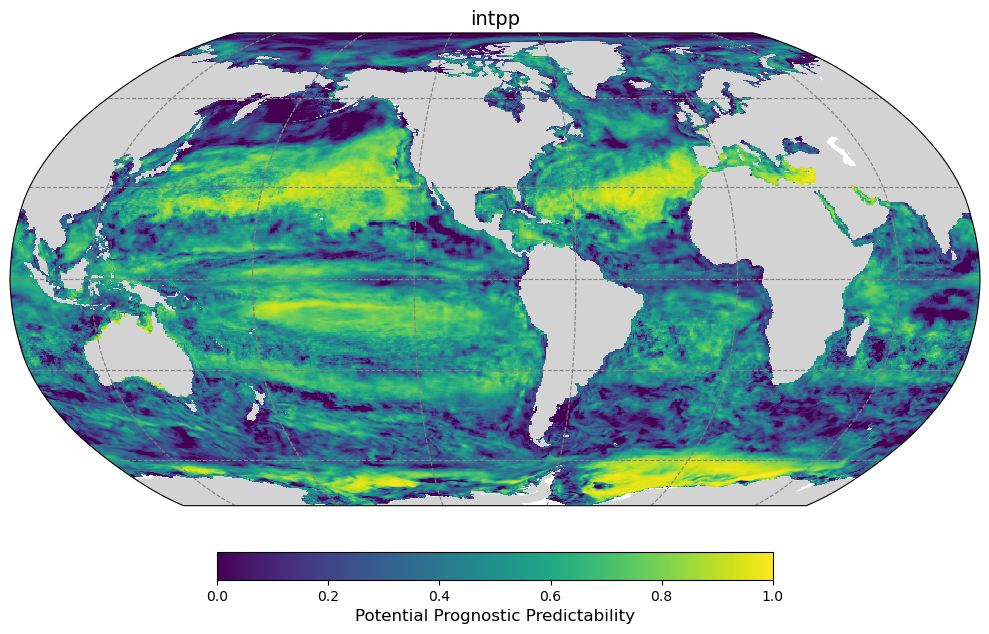

In [83]:
startmonth = 4
ds = calc_ppp(variable,frequency,startmonth=startmonth)
fig,ax,im = draw_globalmap(ds[variable].sel(time=lead),grid,cname='Potential Prognostic Predictability')
im.set_clim([0,1])

/work/gam/projects/esm4_ppe/data/processed/ppp/ocean_cobalt_omip_2d.07.zarr/intpp already saved.


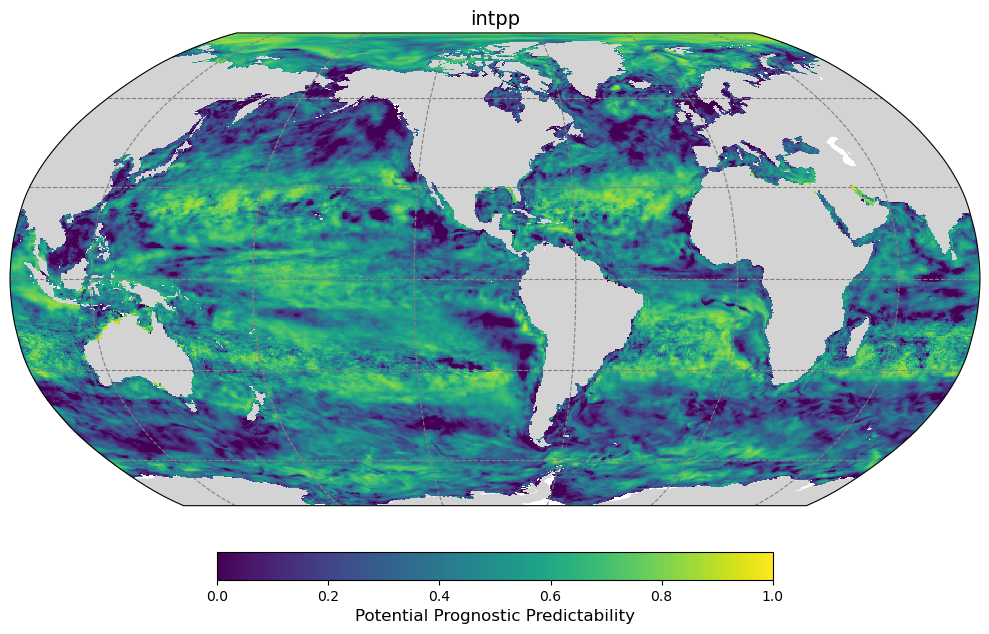

In [84]:
startmonth = 7
ds = calc_ppp(variable,frequency,startmonth=startmonth)
fig,ax,im = draw_globalmap(ds[variable].sel(time=lead),grid,cname='Potential Prognostic Predictability')
im.set_clim([0,1])

### Time horizon, global map

In [138]:
frequency = 'monthly'
smooth = None
startmonth = 10

In [139]:
savedir = ppeDict['datasavedir']+'/processed/ppp_timehorizon/'
savenames = ['*',frequency,str(startmonth).zfill(2)]
if smooth is not None:
    savenames.append('smooth_'+str(smooth))
filename = '.'.join([*savenames,'nc'])
ds = xr.open_mfdataset(savedir+filename)
grid = xr.open_dataset(ppeDict['griddirtmp']+ppeDict['gridfile'])

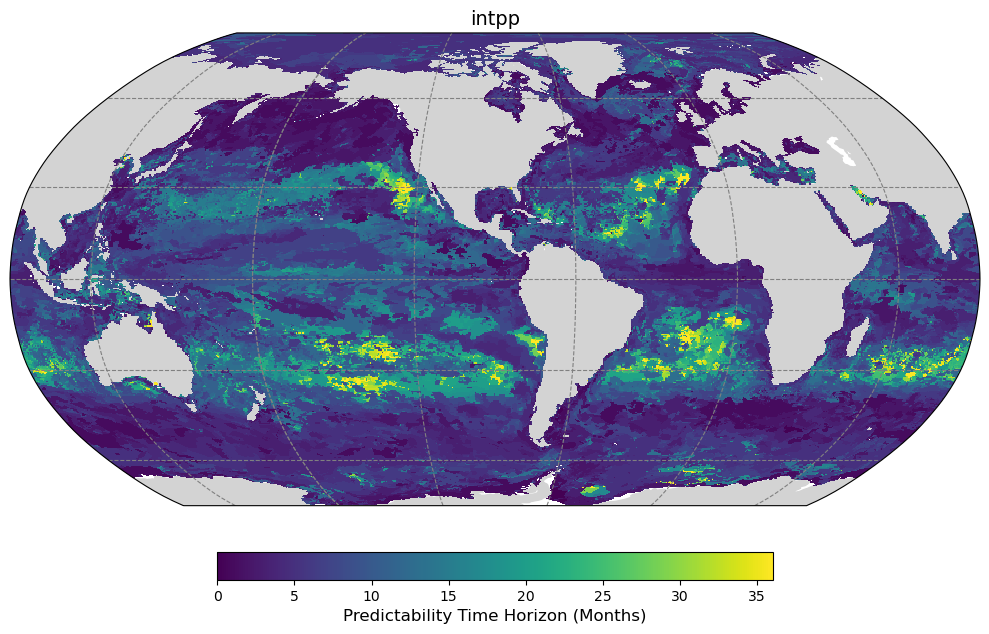

In [140]:
variable = 'intpp'
fig,ax,im = draw_globalmap(ds[variable],grid,cname='Predictability Time Horizon (Months)')
im.set_clim([0,36])
save_fig(fig,'ppp_timehorizon',variable,filename,addnames=['clim36'])

### Regional means : compare variables

In [97]:
def draw_regionalmeans(ds):
    threshold = 0.235559205
    fig,ax=plt.subplots(figsize=(12,4))
    for name,da in ds.items():
        ax.plot(da['time']+1,da,label=name)
    ax.legend(frameon=False)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Potential Prognostic Predictability')
    ax.set_xlim([0,da['time'].max()])
    ax.set_ylim([0,1])
    ax.axhline(threshold,linestyle='--',color='gray')
    return ax

In [98]:
savedir = ppeDict['datasavedir']+'/processed/skill_regionalmeans/ppp.e2c/'
maskset = 'global'
startmonth = 1
filename = '.'.join(['*',frequency,str(startmonth).zfill(2),maskset,'nc'])
ds = xr.open_mfdataset(savedir+filename)

<Axes: xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

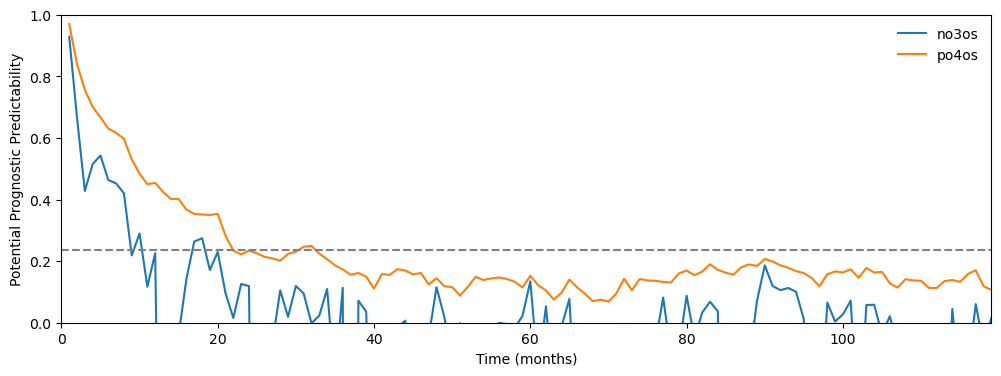

In [102]:
region = 'pacific_T'
variables = ['no3os','po4os']
draw_regionalmeans(ds[variables].sel(region=region))

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

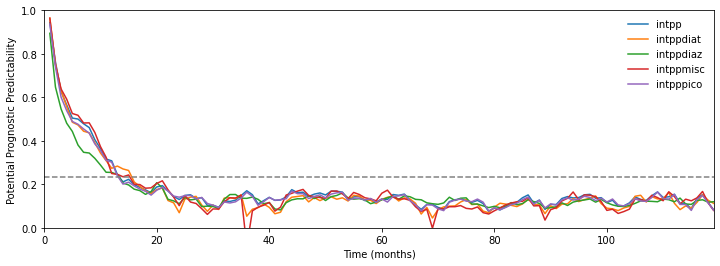

In [12]:
variables = ['intpp','intppdiat','intppdiaz','intppmisc','intpppico']
draw_regionalmeans(ds[variables])

### Regional means : compare regions

In [13]:
variable = 'intpp'

In [14]:
savedir = ppeDict['datasavedir']+'/processed/ppp_regionalmeans/'
filename = '.'.join([variable,frequency,'*','nc'])
def preprocess(ds):
    filename_components = os.path.basename(ds.encoding["source"]).split('.')
    variable = filename_components[0]
    maskname = filename_components[-2]
    return ds.rename({variable:maskname})
ds = xr.open_mfdataset(savedir+filename,preprocess=preprocess)

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

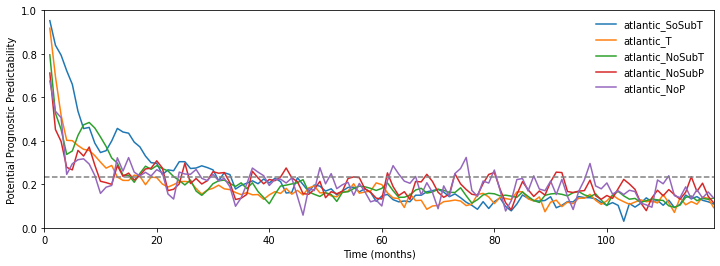

In [15]:
regions = ['atlantic_SoSubT','atlantic_T','atlantic_NoSubT','atlantic_NoSubP','atlantic_NoP']
draw_regionalmeans(ds[regions])

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

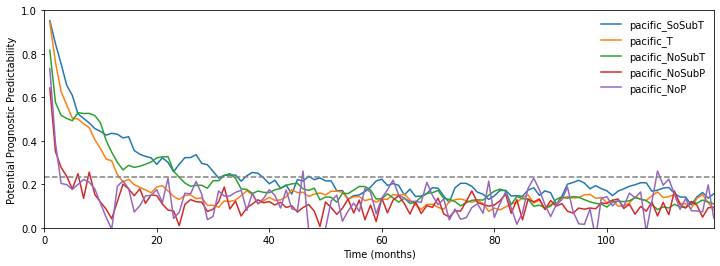

In [16]:
regions = ['pacific_SoSubT','pacific_T','pacific_NoSubT','pacific_NoSubP','pacific_NoP']
draw_regionalmeans(ds[regions])

<AxesSubplot:xlabel='Time (months)', ylabel='Potential Prognostic Predictability'>

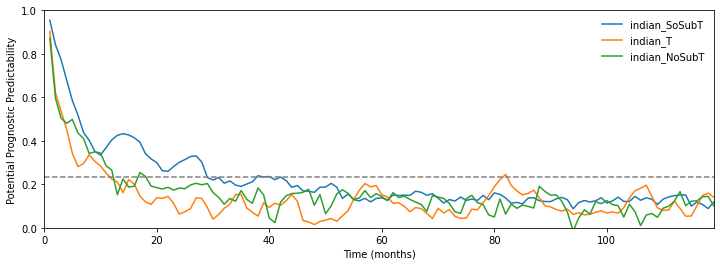

In [17]:
regions = ['indian_SoSubT','indian_T','indian_NoSubT']
draw_regionalmeans(ds[regions])

### Regional means: compare start months

In [14]:
savedir = ppeDict['datasavedir']+'/processed/skill_regionalmeans/ppp.e2c/'
frequency = 'monthly'
maskset = 'global'
def preprocess(ds):
    filename_components = os.path.basename(ds.encoding["source"]).split('.')
    startmonth = filename_components[-3]
    return ds.isel(time=slice(0,36)).expand_dims({'init':[int(startmonth)]})
filename = '.'.join(['*',frequency,'*',maskset,'nc'])
ds = xr.open_mfdataset(savedir+filename,preprocess=preprocess)

In [45]:
variable = 'intpp'
region = 'southern'
da = ds[variable].sel(region=region)

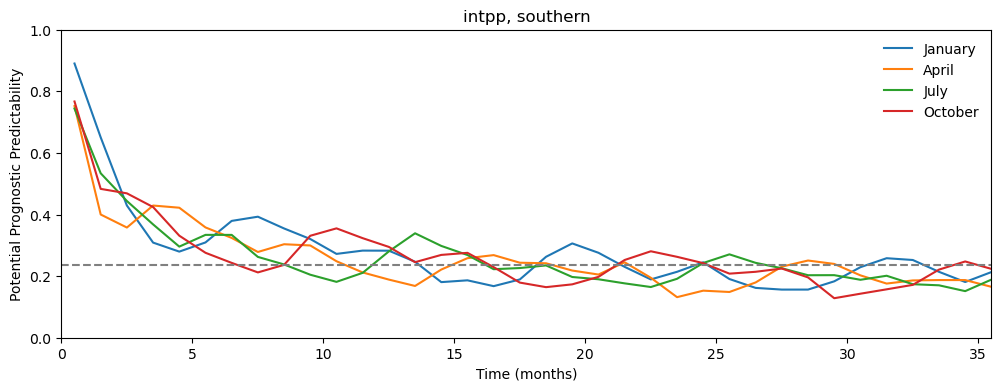

In [46]:
threshold = 0.235559205
month = {1:'January',4:'April',7:'July',10:'October'}
fig,ax = plt.subplots(figsize=(12,4))
for init in da['init']:
    ax.plot(da['time']+0.5,da.sel(init=init),label=month[int(init)])
ax.legend(frameon=False)
ax.set_xlabel('Time (months)')
ax.set_ylabel('Potential Prognostic Predictability')
ax.set_xlim([0,da['time'].max()+0.5])
ax.set_ylim([0,1])
ax.set_title(variable+', '+region)
ax.axhline(threshold,linestyle='--',color='gray')
save_fig(fig,
         figname='ppp',
         variable=variable,
         filename='.'.join([frequency,maskset]),
         addnames=[region,'cfinitmonth'])

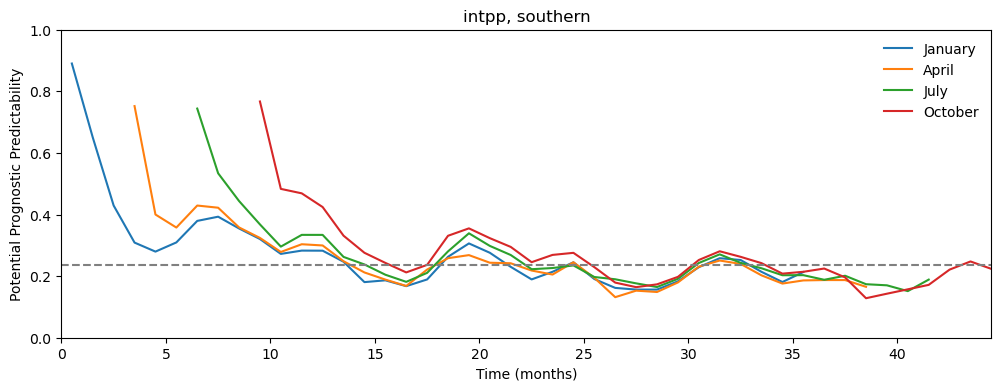

In [47]:
threshold = 0.235559205
month = {1:'January',4:'April',7:'July',10:'October'}
fig,ax = plt.subplots(figsize=(12,4))
for init in da['init']:
    ax.plot(da['time']+int(init)-0.5,da.sel(init=init),label=month[int(init)])
ax.legend(frameon=False)
ax.set_xlabel('Time (months)')
ax.set_ylabel('Potential Prognostic Predictability')
ax.set_xlim([0,da['time'].max()+9.5])
ax.set_ylim([0,1])
ax.set_title(variable+', '+region)
ax.axhline(threshold,linestyle='--',color='gray')
save_fig(fig,
         figname='ppp',
         variable=variable,
         filename='.'.join([frequency,maskset]),
         addnames=[region,'cfinitmonth_shifted'])

### Zonal means

In [92]:
savedir = ppeDict['datasavedir']+'/processed/ppp_zonalmeans/'
startmonth = 1
maskname = 'global'
filename = '.'.join(['*',frequency,str(startmonth).zfill(2),maskname,'nc'])
ds = xr.open_mfdataset(savedir+filename)

In [93]:
def draw_zonalmeans(da):
    mask = (da<ppp_threshold)
    
    fig,ax = plt.subplots(figsize=(4,12))
    im = ax.pcolormesh(da['time'],da['geolat_bin'],da.transpose(),shading='auto')
    ax.contourf(da['time'],da['geolat_bin'],mask.transpose(), 1, hatches=['', '///'], alpha=0)
    im.set_clim([0,1])
    im.set_cmap(mpl.colormaps['YlOrRd'])
    ax.set_xlim([-0.5,35.5])
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Latitude ($^\circ N$)')
    ax.set_title(da.name,fontsize=14)
    cb = fig.colorbar(im,ax=ax,orientation='vertical',pad=0.05,fraction=0.04)
    cb.set_label('Potential Prognostic Predictability',fontsize=14)
    return fig,ax

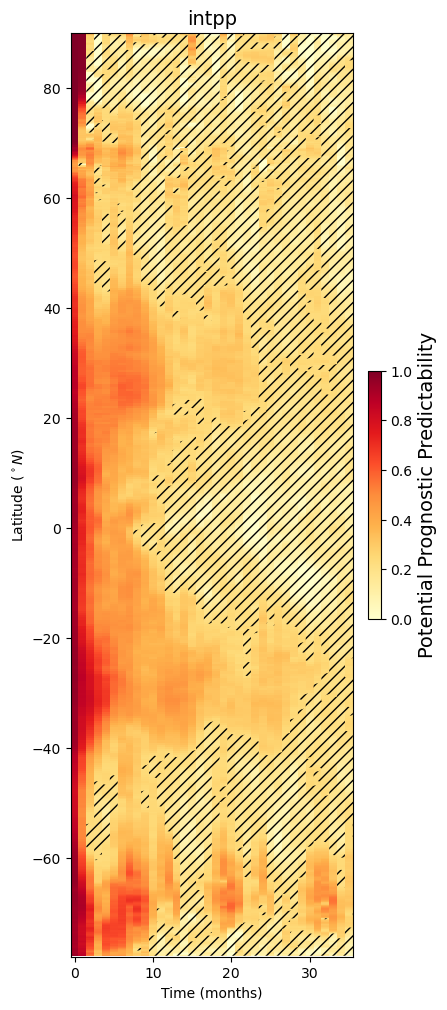

In [94]:
variable = 'intpp'
da = ds[variable]
fig,ax = draw_zonalmeans(da)
save_fig(fig,
         figname='ppp',
         variable=variable,
         filename='.'.join([frequency,maskname]),
         addnames=['zonalmean'])

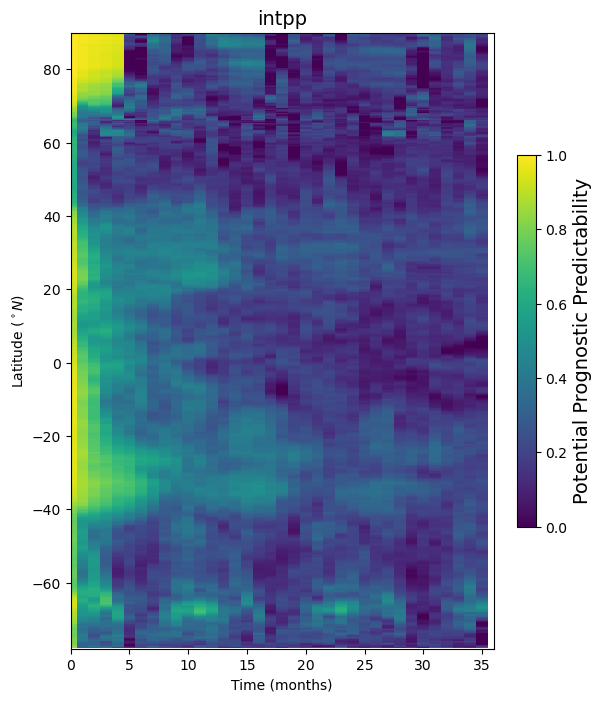

In [171]:
variable = 'intpp'
da = ds[variable]
draw_zonalmeans(da)

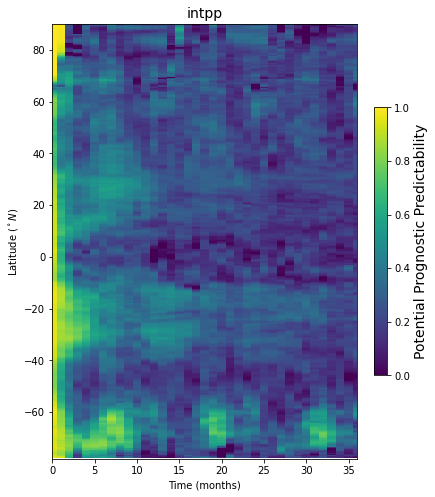

In [21]:
variable = 'intpp'
da = ds[variable]
draw_zonalmeans(da)

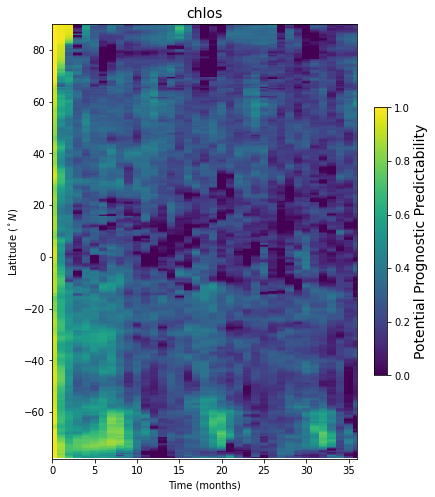

In [22]:
variable = 'chlos'
da = ds[variable]
draw_zonalmeans(da)